In [4]:
#!/usr/bin/env python
from scipy import arange
from numpy import *
import time
from matplotlib.pyplot import *
from modelEquations import *
from MFBfunctions import *
from parameters import *

Setting up system...
checking geometry...
Go ahead! All good with the geometry
Number of compartments: 1


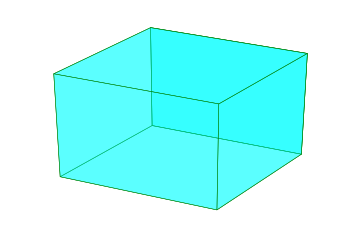

"\nc0 = '0-0-0'\ncModels[0] = mfb({'Ca':[], 'PMCA': [], 'calbindin': []},\n                 name = c0,\n                 dim = cmpts[c0],\n                 nbrs = getNeighbours({c0: cmpts[c0]}, cmpts))\n"

In [5]:
### Command line arguments
cmdArg = {
    'tcp'  : 50e-3,
    'geo'  : 0,
    'save' : 1,
    'tf'   : 100e-3,
    'tstep': 1e-3,
    'fig'  : 1,
    'rtol' : 1e-4,
    'atol' : 1e-10,
    'simName': 'trial/'
}

print "Setting up system..."
simName = 'trial/'

### Geometrical arrangement of all the compartments
### a:n   = a, a+1, a+2,...,n-1
### a:n:i = a, a+i, a+2*i,..., until (n-1)
modelInput = '''[0:2:2, 0:20:4, 0:2:3]
                [38:40:2, 0:20:4, 0:2:3]
                [0:40:5, 0:20:5, 7:10:3]
                [0:40:4, 0:20:5, 5:7:2]
                [0:40:2, 0:20:4, 3:5:2]
                [2:38:2, 0:20:2, 2:3]
                [2:38, 0:20, 0:2]
                '''

modelInput = "[0:1,0:1,0:1]"
#modelInput = "[0:2,0:1,0:1]"

### MFB bounding box
#bb = [40, 20, 10]
bb = [1]*3 #+ [1]*2
boundingBox = "[0:" + str(bb[0]) + ",0:" + str(bb[1]) + ",0:" + str(bb[2]) + "]"

### Get all the compartments as
### {'i-j-k': [i,j,k,lenth,width,height]}
cmpts = compartments(modelInput)
#for k in sorted(cmpts.iterkeys()): print "%s: %s" % (k, cmpts[k])

### Check if no compartment have overlapping volumes and
### there are no gaps in the model
print "checking geometry..."
if checkGeometry(boundingBox, cmpts):
    print 'Go ahead! All good with the geometry'
    print 'Number of compartments:', len(cmpts)
    plotCompartments(cmpts, bb)

### List of model objects for each compartment
cModels = []
for cname, cdim in [[k, cmpts[k]] for k in sorted(cmpts.iterkeys())]: # sorted by name
    cModels.append(mfb({'Ca':[10e-7], 'PMCA': []},# 'PMCA': [], 'calbindin': []},
                  name = cname,
                  dim = cdim,
                  nbrs = getNeighbours({cname: cdim}, cmpts))
                 )
'''
c0 = '0-0-0'
cModels[0] = mfb({'Ca':[], 'PMCA': [], 'calbindin': []},
                 name = c0,
                 dim = cmpts[c0],
                 nbrs = getNeighbours({c0: cmpts[c0]}, cmpts))
'''

In [3]:
result.solve(cModels, cmdArg=cmdArg, flux=1e4)

Total number of equations: 4
solving the ODE...
t = 0
t = 0.01
t = 0.02
t = 0.03
t = 0.04
Time taken for saving: 0.00208592414856
t = 0.05
t = 0.06
t = 0.07
t = 0.08
t = 0.09
t = 0.1
Time taken for saving: 0.00148391723633


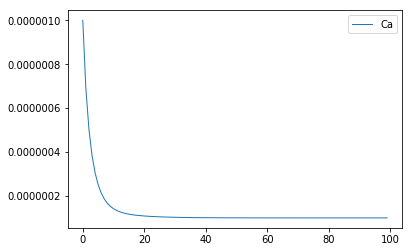

In [4]:
### Plot some results
if cmdArg['fig']:
    fig, ax = subplots()
    for cname, c in result.data.items():
        for vname, v in result.data[cname].items():
            if vname == 'Ca':
                plot(result.t*1e3, v, lw=1, label=vname)
    legend()
    show()#'''